# トピック分析

トピック分析と生成 AI を活用してインサイトを得ます。

以下のステップでテキスト群から主要なインサイトを抽出します。

1. BERTopic でテキストを埋め込みに変換
1. UMAP で時限削減
1. HDBScan でクラスタリング
1. Claude3 で主要なクラスタを解説

トピック分析は[こちら](https://zenn.dev/nishimoto/articles/74fddcb5c67960)の記事を参考にしました。

In [1]:
!pip install bertopic -qU

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.2 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.18.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pylint 3.0.2 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import pandas as pd
from umap import UMAP
from bertopic import BERTopic
from IPython.display import display
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# 日本語サンプルデータとして Megagon Labs の偽のホテルレビューを使用　(cc-by-4)
# https://github.com/megagonlabs/quasi_japanese_reviews

# データのダウンロード
url = "https://raw.githubusercontent.com/megagonlabs/quasi_japanese_reviews/main/data/vanilla/hotel/quasi_hotel.VanillaUtterance.jsonl"
response = requests.get(url)

# データの保存
with open("quasi_hotel.VanillaUtterance.jsonl", "wb") as f:
    f.write(response.content)

In [4]:
# データのロード
quasi_hotel = pd.read_json("quasi_hotel.VanillaUtterance.jsonl", lines=True)
df_docs = pd.DataFrame({
    "data": [utterance["text"] for utterances in quasi_hotel["utterances"] for utterance in utterances],
})

In [5]:
display(df_docs)

,data
0,10月の出張時に一人で一泊しました。
1,旅行サイト経由で予約をしました。
2,予約時に特別プランとあり、他の部屋や近隣のホテルよりも格安であったことが決め手でした。
3,仕事の終わりが遅く、予定より遅れて夜11時過ぎにチェックインしましたが、スタッフの方の対応が...
4,宿泊中は他の宿泊客に会わずとても静かでした。
...,...
5106,お風呂は白濁した珍しい天然温泉なので、テンションが上りました。
5107,料理は美味しかったのですが、少々量が物足りませんでした。
5108,注文できるアルコール類の品目数も物足りない感じでした。
5109,ゲームコーナーに関してはラインナップが古く、とても通好みでした。


In [6]:
# データを見てみる
print("## DataExample")
print("```")
for i in range(5):
    print(df_docs.loc[i, "data"])
    print("---")
print("```")


## DataExample
```
10月の出張時に一人で一泊しました。
---
旅行サイト経由で予約をしました。
---
予約時に特別プランとあり、他の部屋や近隣のホテルよりも格安であったことが決め手でした。
---
仕事の終わりが遅く、予定より遅れて夜11時過ぎにチェックインしましたが、スタッフの方の対応が良かったです。
---
宿泊中は他の宿泊客に会わずとても静かでした。
---
```


In [7]:
# 計算量的な問題により、1000件のみに絞る
df_docs = df_docs.sample(1000, random_state=0)

In [8]:
# BERTopicによるクラスタリング
# 結果を固定したい場合は umapのrandom_stateを0にして固定
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)

# BERTopicモデルの規定
topic_model = BERTopic(
    language="japanese",
    verbose=True,
    umap_model=umap_model,
    calculate_probabilities=True,
    nr_topics="20"
)

In [9]:
# topicやprobabilityの計算
topics, probs = topic_model.fit_transform(df_docs["data"])

2024-03-28 01:20:49,256 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-03-28 01:21:09,205 - BERTopic - Embedding - Completed ✓
2024-03-28 01:21:09,206 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-28 01:21:19,611 - BERTopic - Dimensionality - Completed ✓
2024-03-28 01:21:19,612 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-28 01:21:19,689 - BERTopic - Cluster - Completed ✓
2024-03-28 01:21:19,690 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-28 01:21:19,725 - BERTopic - Representation - Completed ✓
2024-03-28 01:21:19,726 - BERTopic - Topic reduction - Reducing number of topics
2024-03-28 01:21:19,758 - BERTopic - Topic reduction - Reduced number of topics from 20 to 20


In [10]:
df_docs["topic_predicted"] = topics
display(df_docs)

,data,topic_predicted
42,露天風呂から見た夕日には大満足。,1
380,悪いと感じることが一つもなくとても満足です。,3
2417,古民家をリノベーションした、落ち着いた雰囲気です。,2
352,シェフの方がいてその場でオムレツを作っているところもあったので、できたてのオムレツを食べるこ...,0
4172,フロントに頼めば対応いただけましたが、デフォルトで加湿器がついていなかったのが残念でした。,1
...,...,...
461,夕食はアラカルトメニューで、牛のステーキを食べましたが、適度な柔らかさと歯ごたえでおいしくい...,0
1393,大浴場を利用させてもらいましたが、欲を言えばドライヤーの数がもう少しあっても良かったかなと感...,1
1391,メニューが季節に合わせたものを楽しめました。,0
2260,近くにコンビニやドラッグストアがあり、飲み物やお菓子を買うのに便利でした。,16


In [11]:
# 各Topicの概要
topic_info = topic_model.get_topic_info()
display(topic_info)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,151,-1_スタッフの方の対応も素晴らしく_また_アメニティも充実していて_ただ,"[スタッフの方の対応も素晴らしく, また, アメニティも充実していて, ただ, 建物の外観が...","[アメニティも充実していて、カミソリ等、無いものでもフロントに連絡すれば手に入ります。, 館..."
1,0,186,0_美味しかったです_朝食はバイキングで_朝食はバイキング形式で_夕食は,"[美味しかったです, 朝食はバイキングで, 朝食はバイキング形式で, 夕食は, 朝食は, ま...","[料理は料金の割に量もあり、美味しかったです。, また、朝食はバイキング形式で、特にフレンチ..."
2,1,106,1_安心して利用できました_また_ありがたかったです_温泉も41度でちょうどよくサウナ,"[安心して利用できました, また, ありがたかったです, 温泉も41度でちょうどよくサウナ,...","[アメニティも充実しており、ドライヤー、加湿器、ポットなど設備が充実していました。, 露天風..."
3,2,104,2_1泊の値段が少し高めですが_料金もそれほど高くなく_料金は少し高いですが_料金は安いし,"[1泊の値段が少し高めですが, 料金もそれほど高くなく, 料金は少し高いですが, 料金は安い...",[のんびり過ごそうと思っていたホテルでしたので、要所要所チェックしましたが、どこも落ち着いて...
4,3,82,3_おはようございます_女将さんが親切丁寧に対応してくれました_基本的に丁寧で好感が持てた_...,"[おはようございます, 女将さんが親切丁寧に対応してくれました, 基本的に丁寧で好感が持てた...","[車で到着した際にも、スタッフの方が両親をサポートしてくださり、とてもありがたかったです。,..."
5,4,75,4_リラックスできました_客室は広くて_清潔感がありました_清潔感のある部屋でした,"[リラックスできました, 客室は広くて, 清潔感がありました, 清潔感のある部屋でした, 清...","[部屋が広く清潔感があって、リラックスできました。, お部屋は和モダンの落ち着いた部屋で、リ..."
6,5,39,5_5分ほどのところです_観光で泊まったのですが_車がなくても駅から送迎があって便利だった_...,"[5分ほどのところです, 観光で泊まったのですが, 車がなくても駅から送迎があって便利だった...","[駅から少々遠いホテルですが、送迎サービスがあり、移動は楽にする事が出来ました。, 駅から近..."
7,6,38,6_次回もぜひ利用したいと思います_また来たいと思います_また機会があれば利用したいです_ま...,"[次回もぜひ利用したいと思います, また来たいと思います, また機会があれば利用したいです,...","[次回もぜひ利用したいと思います。, 次回もぜひ利用したいと思います!, 次回もぜひ利用した..."
8,7,37,7_お世話になりました_更に満月_朝に歩いたら自然を感じられて_木々に囲まれ,"[お世話になりました, 更に満月, 朝に歩いたら自然を感じられて, 木々に囲まれ, 桜や紅葉...",[桜や紅葉の頃だと若干渋滞しますが、滞在した6月上旬は比較的道が空いていましたので、車窓から...
9,8,30,8_お台場フジテレビビルが見え_泊まった部屋からは_海面のキラキラと船の灯りが綺麗でした_玄...,"[お台場フジテレビビルが見え, 泊まった部屋からは, 海面のキラキラと船の灯りが綺麗でした,...","[部屋も綺麗で、窓から見える夕日がとても綺麗で、感動するほどでした。, 泊まった部屋からは、..."


In [44]:
# 生成 AI でトピックを分析しわかりやすいトピック名つける

import boto3
import json

# 指定可能なリージョンはバージニア北部（us-east-1）またはオレゴン（us-west-2）
bedrock = boto3.client('bedrock-runtime', region_name = "us-west-2")

def claude(system, messages):
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 50,
            "system": system,
            "messages": messages
        }
    )
    modelId = 'anthropic.claude-3-haiku-20240307-v1:0'
    accept = 'application/json'
    contentType = 'application/json'
    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    answer = response_body["content"][0]["text"]
    return answer


def summarize(texts):
    prompt = "テキスト分析ツールとして与えられた複数のテキストのトピックを要約し10文字以内のラベルを1つだけつけてください。出力のみ<label></label>で囲みラベルのみ出力してください。"
    summary = claude(
        prompt,
        [
            {"role": "user", "content": "\n".join([f"<text>{text}</text>" for text in texts])},
        ]
    )
    return summary.replace("<label>", "").replace("</label>", "")

In [45]:
# デフォルトで Representation は 10 件主要なテキストを抽出する
# デフォルトで Representative_Docs は 3 件主要なテキストを抽出する
topic_names = {idx: f"{idx}_{summarize(rd)}" for idx, rd in enumerate(topic_info["Representation"][1:])}
topic_names[-1] = "その他"
print(topic_names)
topic_model.set_topic_labels(topic_names)

{0: '0_朝食バイキング', 1: '1_温泉体験', 2: '2_料金と建物', 3: '3_良好なサービス', 4: '4_快適な宿泊体験', 5: '5_送迎サービス付きの宿泊', 6: '6_利用したい再訪', 7: '7_自然体験', 8: '8_景色', 9: '9_思い出深い体験', 10: '10_ホテル情報', 11: '11_駐車場', 12: '12_旅行・宿泊', 13: '13_宿泊施設体験', 14: '14_地酒充実のアルコール提供', 15: '15_ホテル周辺の買い物環境', 16: '16_周辺施設充実', 17: '17_スムーズで充実した滞在', 18: '18_観光リッチなホテル立地', -1: 'その他'}


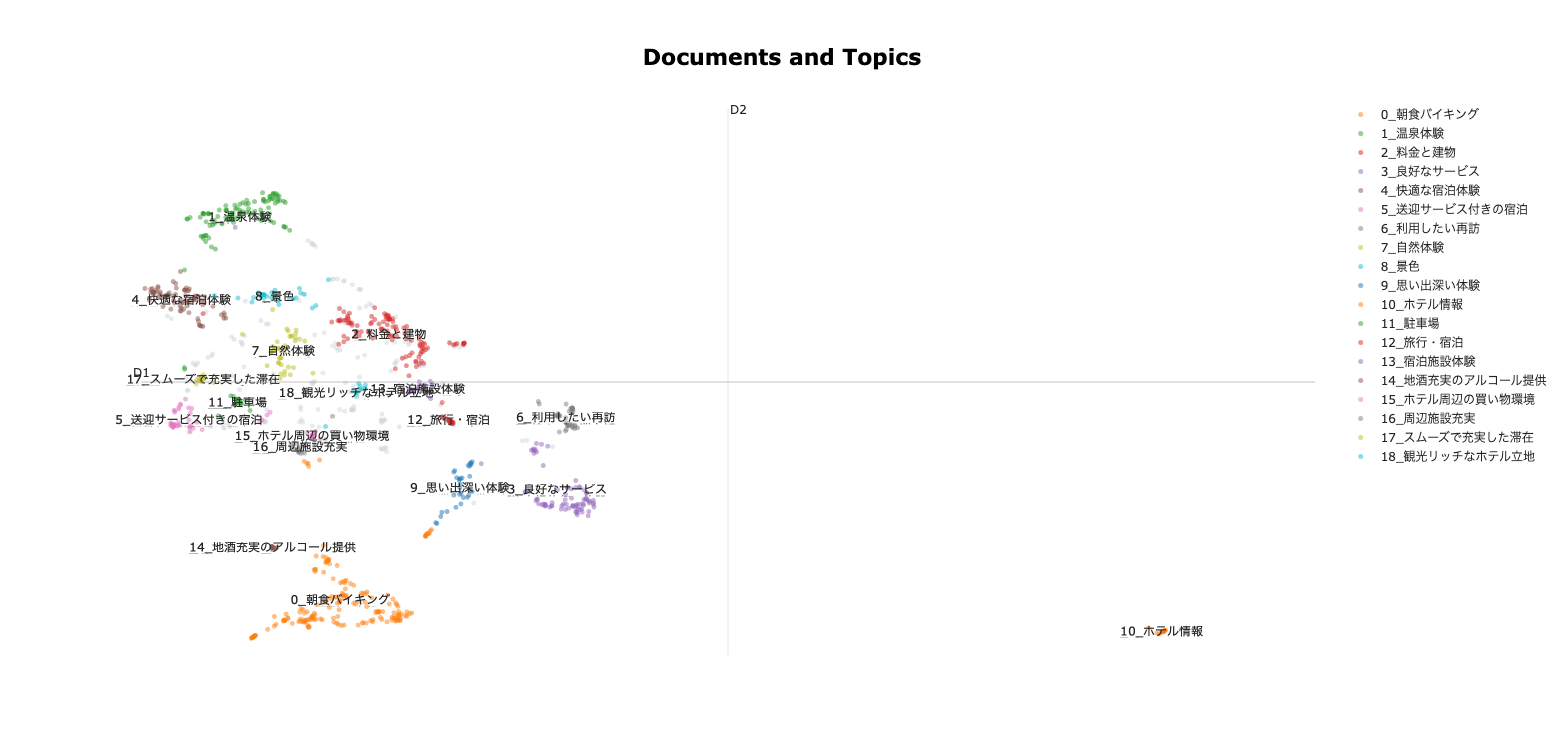

In [46]:
# 可視化
topic_model.visualize_documents(df_docs["data"].values, custom_labels=True)

BERTopic では他にも様々な可視化が可能。

https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html